In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Question 2: Dimensionality Reduction

[2.1] Reducing the dimensionality of the dataset to two dimensions using a) Autoencoders

In [84]:
df = pd.read_csv('nba_2022-23_stats_cleaned.csv')
df.head()

,Rank,Player Name,Salary,Position,Age,Team,GP,GS,MP,FG,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,1,Stephen Curry,48070014,PG,34,GSW,56,56,34.7,10.0,...,12.5,31.0,5.8,2.0,7.8,0.192,7.5,0.1,7.5,4.7
1,2,John Wall,47345760,PG,32,LAC,34,3,22.2,4.1,...,17.1,27.0,-0.4,0.7,0.3,0.020,-0.8,-0.4,-1.2,0.1
2,3,Russell Westbrook,47080179,PG,34,LAL/LAC,73,24,29.1,5.9,...,18.4,27.7,-0.6,2.6,1.9,0.044,0.3,-0.1,0.2,1.2
3,4,LeBron James,44474988,PF,38,LAL,55,54,35.5,11.1,...,11.6,33.3,3.2,2.4,5.6,0.138,5.5,0.6,6.1,4.0
4,5,Kevin Durant,44119845,PF,34,BRK/PHO,47,47,35.6,10.3,...,13.4,30.7,4.7,2.1,6.8,0.194,6.0,1.2,7.1,3.9


In [85]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

**Data Preprocessing:** Drop non-numeric columns and normalise the data as Autoencoders work best with scaled data. Encode player positions.

In [86]:
# All the types of positions
positions = df['Position'].unique()
print(f'positions: {positions}')

# One-hot encoding for Position column
df = pd.get_dummies(df, columns=['Position'])
display(df.head())

positions: ['PG' 'PF' 'SG' 'SF' 'PG-SG' 'C' 'SG-PG' 'SF-SG' 'SF-PF']


,Rank,Player Name,Salary,Age,Team,GP,GS,MP,FG,FGA,...,VORP,Position_C,Position_PF,Position_PG,Position_PG-SG,Position_SF,Position_SF-PF,Position_SF-SG,Position_SG,Position_SG-PG
0,1,Stephen Curry,48070014,34,GSW,56,56,34.7,10.0,20.2,...,4.7,0,0,1,0,0,0,0,0,0
1,2,John Wall,47345760,32,LAC,34,3,22.2,4.1,9.9,...,0.1,0,0,1,0,0,0,0,0,0
2,3,Russell Westbrook,47080179,34,LAL/LAC,73,24,29.1,5.9,13.6,...,1.2,0,0,1,0,0,0,0,0,0
3,4,LeBron James,44474988,38,LAL,55,54,35.5,11.1,22.2,...,4.0,0,1,0,0,0,0,0,0,0
4,5,Kevin Durant,44119845,34,BRK/PHO,47,47,35.6,10.3,18.3,...,3.9,0,1,0,0,0,0,0,0,0


In [87]:
# Drop non-numeric columns
features = df.drop(columns=['Player Name', 'Team'])

# Normalise the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features


array([[-1.72833794,  3.71021079,  1.91346367, ..., -0.04637389,
        -0.57239438, -0.06565322],
       [-1.72090423,  3.64248807,  1.44563887, ..., -0.04637389,
        -0.57239438, -0.06565322],
       [-1.71347052,  3.61765443,  1.91346367, ..., -0.04637389,
        -0.57239438, -0.06565322],
       ...,
       [ 1.71347052, -0.78165715,  0.74390167, ..., -0.04637389,
         1.7470472 , -0.06565322],
       [ 1.72090423, -0.78411844, -0.65957273, ..., -0.04637389,
        -0.57239438, -0.06565322],
       [ 1.72833794, -0.78411844, -0.42566033, ..., -0.04637389,
        -0.57239438, -0.06565322]])

**Build the Autoencoder Model:** Define an Autoencoder with an encoding dimension of 2.

- Explanation of Layer Sizes:
    - The initial layer sizes (32, 16, and 8) allow a gradual reduction, which helps the model learn to compress data effectively without losing too much information.
    - The encoding layer is set to 2 neurons to achieve your goal of reducing the data to two dimensions.
    - This structure allows the model to distill information effectively from the 49 features down to just 2 while minimizing reconstruction loss.

In [88]:
input_dim = scaled_features.shape[1]
print(f'Input dimension: {input_dim}')

encoding_dim = 2 # Target dimension
print(f'Encoding target dimension: {encoding_dim}')

input_layer = Input(shape=(input_dim,))

# Encode layers with progressive reduction in dimensions
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dense(8, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded) # Final 2D encoding

# Decode layers with progressive increase in dimensions back to 49 features
decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(decoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded) # Output layer for reconstruction

# Define the autoencoder model
autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

Input dimension: 58
Encoding target dimension: 2


**Train the Autoencoder:**

In [89]:
autoencoder.fit(scaled_features, scaled_features, epochs=500, batch_size=32, shuffle=True, validation_split=0.2)

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.0678 - val_loss: 2.0325
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9900 - val_loss: 2.0008
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9948 - val_loss: 1.8894
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9335 - val_loss: 1.6925
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8831 - val_loss: 1.5226
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7787 - val_loss: 1.4476
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7861 - val_loss: 1.4356
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7656 - val_loss: 1.4338
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7048 - val_loss: 1.4351
Epoch 10/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7865 - val_loss: 1.4357
Epoch 11/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6464 - val_loss: 1.4352
Epoch 12/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

**Extract the Encoded (Reduced) Data:** After training, use encoder of model to get reduced data and convert reduced data to new DataFrame for easier handling.

In [90]:
reduced_features = encoder.predict(scaled_features)
print(f'Reduced features: {reduced_features}')

# Convert the reduced features to a DataFrame
reduced_df = pd.DataFrame(reduced_features, columns=[f'feature_{i}' for i in range(encoding_dim)])

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Reduced features: [[1.93233585e+01 5.33139229e+01]
 [7.21379929e+01 3.95549698e+01]
 [2.59533310e+01 4.01077957e+01]
 [1.60597038e+01 5.60068588e+01]
 [1.68168259e+01 6.03344574e+01]
 [3.18031693e+01 5.82519341e+01]
 [1.48874788e+01 4.26130028e+01]
 [2.64597187e+01 5.43721199e+01]
 [7.13848448e+00 4.53263359e+01]
 [2.46483746e+01 7.43723297e+01]
 [4.25331268e+01 5.31255913e+01]
 [1.58211985e+01 4.59427795e+01]
 [1.10875881e+00 7.23089266e+00]
 [3.26654587e+01 4.58333321e+01]
 [0.00000000e+00 2.43211308e+01]
 [6.61408710e+00 4.48555450e+01]
 [1.43512993e+01 1.77289295e+01]
 [8.05705872e+01 3.55958214e+01]
 [3.34012947e+01 7.08471146e+01]
 [2.55817051e+01 5.24205933e+01]
 [9.88438416e+00 1.18707085e+01]
 [1.28207636e+01 3.75354958e+01]
 [2.21621776e+00 1.11745396e+01]
 [1.48275747e+01 3.18844776e+01]
 [1.17942085e+01 3.27213020e+01]
 [2.68414917e+01 6.16215553e+01]
 [2.29690266e+01 2.79746971e+01]
 [0.00000000e+00 4.49174194e+01]
 [2.92492371e+01 4

**Visualising the Reduced Dataset:** Applying K-Means clustering and plotting the reduced dataset with clusters.

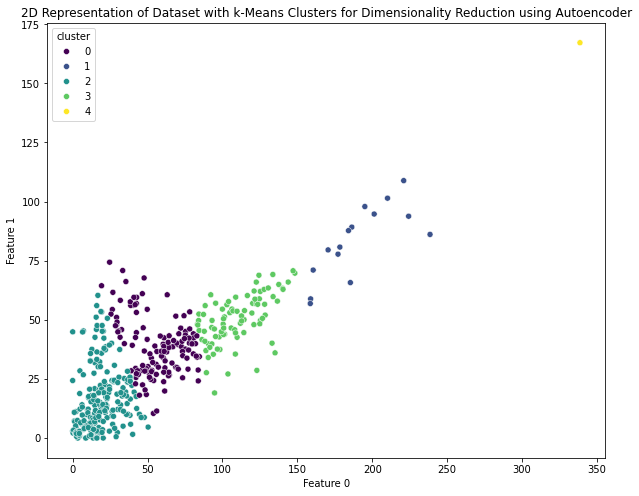

In [91]:
# Apply KMeans clustering to the reduced features
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(reduced_df)

# Add the cluster labels to the DataFrame
reduced_df['cluster'] = clusters

# Plotting reduced features with cluster labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x='feature_0', y='feature_1', data=reduced_df, hue='cluster', palette='viridis')
plt.title('2D Representation of Dataset with k-Means Clusters for Dimensionality Reduction using Autoencoder')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.savefig('Question_2_Plots/Autoencoder_Clustering_2-1-a.pdf')
plt.show()